In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Start by using the 20k dataset
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [3]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [4]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text file) and returns the lines of text as a list.

    Args:
        filename: a string containing the target filepath to read.

    Returns:
        A list of strings with one string per line from the target filename.
        For example:
        ["this is the first line of filename",
        "this is the second line of filename",
        "..."]
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [5]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
def preprocess_text_with_line_numbers(filename):
    """Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.

    Args:
        filename: a string of the target text file to read and extract line data
        from.

    Returns:
        A list of dictionaries each containing a line from an abstract,
        the lines label, the lines position in the abstract and the total number
        of lines in the abstract where the line is from. For example:

        [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
    """
    input_lines = get_lines(filename) # get all lines from filenames
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list for abstracts

    # loop through each line in target file
    for line in input_lines:
        if line.startswith("###"): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset abstract string
        elif line.isspace(): # check if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines

            # iterate through each line in abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create empty dict to store data from line
                target_text_split = abstract_line.split('\t') # split target label from text
                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) - 1 # start from 0
                abstract_samples.append(line_data)
        
        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [7]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [8]:
# check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [10]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

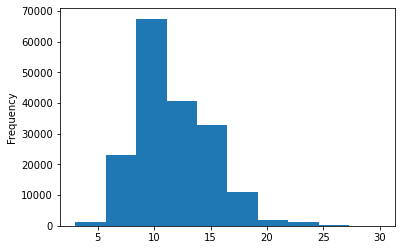

In [11]:
train_df.total_lines.plot.hist()

In [12]:
# convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [13]:
# view the first 10 lines of sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [14]:

# onehot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [15]:
# label encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [16]:
# get class names and number of classes from labelencoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [17]:
# baseline model 0: tf-idf naive bayes 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

# fit pipeline to train data
model_0.fit(
    X=train_sentences,
    y=train_labels_encoded
)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
# evaluate baseline model on validation dataset
model_0.score(
    X=val_sentences,
    y=val_labels_encoded
)

0.7218323844829869

In [19]:
# make predictions using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [20]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [21]:
from helper_functions import calculate_results

In [22]:
# calculate bseline results
baseline_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=baseline_preds
)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [24]:
# how long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
median_sent_len = np.median(sent_lens)
avg_sent_len, median_sent_len

(26.338269273494777, 23.0)

(array([6.6700e+02, 1.1680e+03, 2.7870e+03, 4.4910e+03, 7.3860e+03,
        8.9870e+03, 1.0807e+04, 1.1710e+04, 1.2535e+04, 1.2625e+04,
        1.2223e+04, 1.1578e+04, 1.0608e+04, 9.6880e+03, 8.5860e+03,
        7.5960e+03, 6.6380e+03, 5.7720e+03, 4.8830e+03, 4.1610e+03,
        3.5490e+03, 2.9750e+03, 2.5220e+03, 2.1700e+03, 1.8950e+03,
        1.5950e+03, 1.4080e+03, 1.1490e+03, 1.0530e+03, 4.5600e+02,
        8.1100e+02, 7.0900e+02, 5.5800e+02, 4.9500e+02, 4.7600e+02,
        3.8800e+02, 3.3700e+02, 2.9300e+02, 2.6500e+02, 2.3600e+02,
        2.0000e+02, 1.6400e+02, 1.5000e+02, 1.5300e+02, 1.4100e+02,
        1.1900e+02, 9.0000e+01, 8.4000e+01, 6.7000e+01, 7.2000e+01,
        6.4000e+01, 4.6000e+01, 4.1000e+01, 3.8000e+01, 3.7000e+01,
        3.3000e+01, 3.0000e+01, 2.6000e+01, 2.6000e+01, 1.3000e+01,
        1.9000e+01, 1.6000e+01, 1.4000e+01, 1.9000e+01, 9.0000e+00,
        8.0000e+00, 1.3000e+01, 8.0000e+00, 5.0000e+00, 5.0000e+00,
        6.0000e+00, 1.2000e+01, 6.0000e+00, 3.00

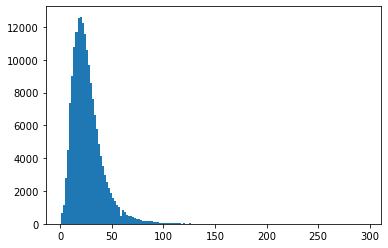

In [25]:
# what's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=150)


In [26]:
# how long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [27]:
# maximum sequence length in the training set
max(sent_lens)

296

In [28]:
# how many words are in our vocab (from the paper, it's 68k)
max_tokens = 68000

In [29]:
# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(
    max_tokens=max_tokens, # number of words in vocab
    output_sequence_length=output_seq_len # desired output length of vectorized sequences
    )

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-01-04 16:33:11.941224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-04 16:33:11.941362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
# adapt text vectorizer to training sentences
text_vectorizer.adapt(
    train_sentences
)

2022-01-04 16:33:12.547566: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-04 16:33:12.547728: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-04 16:33:12.585526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [31]:
# test text vectorizer on rondom sentences
import random
target_sentence = random.choice(train_sentences)
print(f"text:\n{target_sentence}")
print(f"\nlength of text: {len(target_sentence.split())}")
print(f"\nvectorized text: {text_vectorizer([target_sentence])}")


text:
there were no completed suicides , and only @ participants reported suicide attempts at follow-up .

length of text: 16

vectorized text: [[   61     9    33   253 21643     3   192    60   205  2793  2569    15
     94     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [32]:
# how many words in our training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"least common words in the vocab: {rct_20k_text_vocab[-5:]}")

number of words in vocab: 64841
most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False}

In [34]:
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab), # length of vocab
    output_dim=128, # different embedding numbers lead to different parameters
    mask_zero=True, # use masking to handle variable sequence lengths(save space)
    name='token_embedding'
)

In [35]:
# show example embedding
print(f"text:\n{target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"\nvectorized text: {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"\nembedded text: {embedded_sentence}")
print(f"embedded sentence shape: {embedded_sentence.shape}")

text:
there were no completed suicides , and only @ participants reported suicide attempts at follow-up .

vectorized text: [[   61     9    33   253 21643     3   192    60   205  2793  2569    15
     94     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

embedded text: [[[ 0.02264519  0.03944364  0.00319403 ...  0.0202426   0.02352263
    0.01712299]
  [ 0.04073367  0.02629515 -0.04125348 ... -0.01147951  0.04292203
    0.00983225]
  [-0.01730217  0.02584774 -0.0157681  ...  0.0396404  -0.01737356
   -0.03333485]
  ...
  [-0.04450257 -0.04102272  0.0396273  ...  0.02507491  0.01097897
   -0.01794311]
  [-0.04450257 -0.04102272  0.0396273  ...  0.02507491  0.01097897
   -0.01794311]
  [-0.04450257 -0.04102272  0.0396273  ...  0.02507491  0.01097897
   -0.01794311]]]
embedded sen

In [36]:
# turn our data into tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset


<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [37]:
# take the tensorslicedatasets and turn them into perfected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [38]:
from tensorflow.keras.optimizers import Adam
# model 1: conv1d
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

In [39]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    mode='min',
    min_delta=0.005
)

history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=100,
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    callbacks=[
        early_stopping
    ]
)

Epoch 1/100
   1/5627 [..............................] - ETA: 27:03 - loss: 1.6025 - accuracy: 0.4375

2022-01-04 16:33:15.810330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.7767

2022-01-04 16:35:10.397452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - 121s 22ms/step - loss: 0.6137 - accuracy: 0.7767 - val_loss: 0.5359 - val_accuracy: 0.8093
Epoch 2/100
5627/5627 [==============================] - 118s 21ms/step - loss: 0.4506 - accuracy: 0.8421 - val_loss: 0.5335 - val_accuracy: 0.8109


In [41]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.5335 - accuracy: 0.8109


[0.5335400700569153, 0.8108698129653931]

In [42]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

2022-01-04 16:37:22.641908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(array([[6.8862206e-01, 4.1857935e-02, 1.3405226e-01, 1.0024623e-01,
         3.5221636e-02],
        [5.6397194e-01, 1.2967516e-01, 4.0371800e-03, 2.8552204e-01,
         1.6793674e-02],
        [2.0389624e-01, 8.2526123e-03, 2.0379273e-03, 7.8569460e-01,
         1.1868646e-04],
        ...,
        [8.2825272e-07, 3.6452639e-05, 1.5547776e-03, 5.7108423e-07,
         9.9840742e-01],
        [1.5378344e-01, 4.9308300e-01, 1.5318282e-01, 3.5744410e-02,
         1.6420634e-01],
        [9.0833744e-03, 9.8744208e-01, 2.8627093e-03, 1.3526625e-04,
         4.7658413e-04]], dtype=float32),
 (30212, 5))

In [43]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [44]:
# calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded, y_pred=model_1_preds)
model_1_results

{'accuracy': 81.08698530385277,
 'precision': 0.8088591231905834,
 'recall': 0.8108698530385278,
 'f1': 0.8080422121366021}

In [45]:
# model 2: feature extraction
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[], # shape of inputs coming to out model
    dtype=tf.string, #input datatype
    trainable=False, # keep the pretrained weights
    name='USE'
    )

2022-01-04 16:37:27.976091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [46]:
# test the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"sentence after embedding:\n {use_embedded_sentence}")
print(f"length of sentence embedding: {len(use_embedded_sentence[0])}")

random sentence:
 the mean age was @ years , and @ patients ( @ % ) were men .
sentence after embedding:
 [[-0.04660344 -0.05064455 -0.03238748  0.031948   -0.08074798  0.01533053
  -0.01097807  0.04835536 -0.08605299 -0.02025109  0.08178901 -0.02510766
  -0.00287411  0.06032244  0.01261282 -0.02901366 -0.0953545  -0.02270275
  -0.01219145 -0.05555991 -0.05963547  0.03887356  0.02267543  0.00956123
   0.03789944 -0.04019895  0.07402705  0.00309864  0.06043407 -0.02110408
  -0.03883559  0.09488346  0.02461785 -0.03792383 -0.07765684  0.01947719
  -0.0180571  -0.06477582  0.07924256 -0.05743477 -0.06305905  0.05597832
   0.00710926  0.04609671  0.00028946  0.0665676   0.0486904   0.05621807
   0.06503493 -0.05133726 -0.00940813 -0.04925968 -0.04590763  0.00814809
   0.03227966  0.01535432  0.00271685  0.02678382  0.06811185 -0.04549425
   0.02940601  0.02242537  0.00792247  0.05906897 -0.00952775  0.00830906
   0.00374073 -0.0277207   0.04205836 -0.0123122   0.05200215 -0.08844189
  -0.0

2022-01-04 16:37:28.722349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [47]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE_feature_extraction')

model_2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

In [48]:
model_2.summary()

Model: "model_2_USE_feature_extraction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [49]:
history_model_2 = model_2.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=len(train_dataset),
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    callbacks=[
        early_stopping
    ]
)

Epoch 1/100


2022-01-04 16:37:29.734799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.7219

2022-01-04 16:40:23.881327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - 214s 38ms/step - loss: 0.7262 - accuracy: 0.7219 - val_loss: 0.6535 - val_accuracy: 0.7518
Epoch 2/100
5627/5627 [==============================] - 227s 40ms/step - loss: 0.6335 - accuracy: 0.7602 - val_loss: 0.6198 - val_accuracy: 0.7636
Epoch 3/100
5627/5627 [==============================] - 231s 41ms/step - loss: 0.5989 - accuracy: 0.7736 - val_loss: 0.6061 - val_accuracy: 0.7688
Epoch 4/100
5627/5627 [==============================] - 233s 41ms/step - loss: 0.5765 - accuracy: 0.7823 - val_loss: 0.6001 - val_accuracy: 0.7720
Epoch 5/100
5627/5627 [==============================] - 235s 42ms/step - loss: 0.5599 - accuracy: 0.7894 - val_loss: 0.5982 - val_accuracy: 0.7736


In [50]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 33s 35ms/step - loss: 0.5982 - accuracy: 0.7736


[0.5981509685516357, 0.7735998630523682]

In [51]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

2022-01-04 16:57:03.275640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[6.37889683e-01, 2.82450199e-01, 6.62917810e-05, 7.81223029e-02,
        1.47146615e-03],
       [5.25388896e-01, 3.68117630e-01, 1.15577097e-03, 1.04753047e-01,
        5.84708992e-04],
       [4.76656586e-01, 4.20798175e-03, 8.55344161e-03, 5.07103682e-01,
        3.47836502e-03],
       ...,
       [1.69407125e-04, 9.05736742e-05, 8.20991583e-03, 4.98998306e-05,
        9.91480112e-01],
       [1.22291213e-02, 1.06475793e-01, 8.52281302e-02, 3.29294498e-03,
        7.92774081e-01],
       [7.94815924e-03, 9.91027296e-01, 9.14881297e-04, 2.62235471e-06,
        1.07030195e-04]], dtype=float32)

In [52]:
# convert prediction probabilities to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [53]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 77.35998940818219,
 'precision': 0.7715852959541243,
 'recall': 0.7735998940818218,
 'f1': 0.7694824348980607}

In [54]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [55]:
# model 3: cov1d with character embeddings
# make functions to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

In [56]:
# text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e   m e a n   a g e   w a s   @   y e a r s   ,   a n d   @   p a t i e n t s   (   @   %   )   w e r e   m e n   .'

In [57]:
# split sequence-level data splits into cahracter-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [58]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [59]:
# what's the avg character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([6.7000e+02, 1.3900e+03, 4.0270e+03, 6.2540e+03, 9.7670e+03,
        1.2155e+04, 1.2906e+04, 1.5233e+04, 1.5572e+04, 1.4717e+04,
        1.3744e+04, 1.2475e+04, 1.1130e+04, 8.7230e+03, 7.8800e+03,
        6.6120e+03, 5.3430e+03, 4.2990e+03, 3.5050e+03, 2.6320e+03,
        2.2170e+03, 1.8000e+03, 1.4280e+03, 1.1320e+03, 8.7700e+02,
        6.5700e+02, 4.7400e+02, 4.6100e+02, 3.4000e+02, 3.0300e+02,
        2.4700e+02, 1.9900e+02, 1.4500e+02, 1.1100e+02, 1.0000e+02,
        8.8000e+01, 7.1000e+01, 4.8000e+01, 4.4000e+01, 3.6000e+01,
        2.9000e+01, 2.9000e+01, 1.8000e+01, 2.9000e+01, 1.3000e+01,
        1.3000e+01, 1.4000e+01, 1.0000e+01, 5.0000e+00, 7.0000e+00,
        9.0000e+00, 3.0000e+00, 5.0000e+00, 5.0000e+00, 7.0000e+00,
        2.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

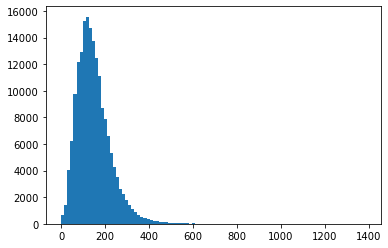

In [60]:
# check the distribution of sequence at char-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=100)

In [61]:
# find what character length covers 95% of sequence
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [62]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
# create char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # 2 for space and OOV token(out of vocab)

char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    #standardize='lower_and_strip_punctuation',
    name='char_vectorizer'
)

In [64]:
# adapt char vectorizer to training character
char_vectorizer.adapt(train_chars)

2022-01-04 16:57:42.840309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [65]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different chars in vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different chars in vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [66]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")



Charified text:
c h a l l e n g e   w i t h   h d m / l p s   i n d u c e d   a   s i g n i f i c a n t   i n c r e a s e   i n   e o s i n o p h i l   c a t i o n i c   p r o t e i n   (   p   =   @   )   a n d   a   t r e n d   t o w a r d   a n   i n c r e a s e   i n   b a l f   e o s i n o p h i l s   a s   c o m p a r e d   t o   h d m   c h a l l e n g e   .

Length of chars: 146

Vectorized chars:
[[11 13  5 12 12  2  6 18  2 20  4  3 13 13 10 15 12 14  9  4  6 10 16 11
   2 10  5  9  4 18  6  4 17  4 11  5  6  3  4  6 11  8  2  5  9  2  4  6
   2  7  9  4  6  7 14 13  4 12 11  5  3  4  7  6  4 11 14  8  7  3  2  4
   6 14  5  6 10  5  3  8  2  6 10  3  7 20  5  8 10  5  6  4  6 11  8  2
   5  9  2  4  6 22  5 12 17  2  7  9  4  6  7 14 13  4 12  9  5  9 11  7
  15 14  5  8  2 10  3  7 13 10 15 11 13  5 12 12  2  6 18  2  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [67]:
# create char embedding layer
char_embed = layers.Embedding(
    input_dim=len(char_vocab),
    output_dim=25,
    mask_zero=True,
    name='char_embed'
    )

In [68]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
c h a l l e n g e   w i t h   h d m / l p s   i n d u c e d   a   s i g n i f i c a n t   i n c r e a s e   i n   e o s i n o p h i l   c a t i o n i c   p r o t e i n   (   p   =   @   )   a n d   a   t r e n d   t o w a r d   a n   i n c r e a s e   i n   b a l f   e o s i n o p h i l s   a s   c o m p a r e d   t o   h d m   c h a l l e n g e   .

Embedded chars (after vectorization and embedding):
[[[ 0.03196801 -0.01276038  0.0057248  ... -0.0134631  -0.00051811
    0.02597034]
  [ 0.0293882   0.03826041 -0.0239161  ... -0.04909274  0.03842462
   -0.00015693]
  [ 0.02507491  0.01097897 -0.01794311 ... -0.04264482  0.01879549
   -0.01251771]
  ...
  [-0.04450257 -0.04102272  0.0396273  ... -0.02766272  0.04036475
   -0.01300174]
  [-0.04450257 -0.04102272  0.0396273  ... -0.02766272  0.04036475
   -0.01300174]
  [-0.04450257 -0.04102272  0.0396273  ... -0.02766272  0.04036475
   -0.01300174]]]

Character embedding shape: (1, 290,

In [69]:
# make cov1d on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embedding")

model_3.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

In [70]:
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
___________________________________

In [71]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
# Fit the model on chars only
model_3_history = model_3.fit(
    train_char_dataset,
    steps_per_epoch=len(train_char_dataset),
    epochs=100,
    validation_data=val_char_dataset,
    validation_steps=len(val_char_dataset),
    callbacks=[
        early_stopping
    ]
    )

Epoch 1/100


2022-01-04 16:57:45.778729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - ETA: 0s - loss: 0.8859 - accuracy: 0.6522

2022-01-04 17:00:46.235533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - 194s 34ms/step - loss: 0.8859 - accuracy: 0.6522 - val_loss: 0.7927 - val_accuracy: 0.6894
Epoch 2/100
5627/5627 [==============================] - 206s 37ms/step - loss: 0.7501 - accuracy: 0.7134 - val_loss: 0.7528 - val_accuracy: 0.7081
Epoch 3/100
5627/5627 [==============================] - 207s 37ms/step - loss: 0.7171 - accuracy: 0.7278 - val_loss: 0.7382 - val_accuracy: 0.7151
Epoch 4/100
5627/5627 [==============================] - 210s 37ms/step - loss: 0.6992 - accuracy: 0.7353 - val_loss: 0.7324 - val_accuracy: 0.7173
Epoch 5/100
5627/5627 [==============================] - 206s 37ms/step - loss: 0.6866 - accuracy: 0.7410 - val_loss: 0.7244 - val_accuracy: 0.7222
Epoch 6/100
5627/5627 [==============================] - 201s 36ms/step - loss: 0.6769 - accuracy: 0.7449 - val_loss: 0.7138 - val_accuracy: 0.7262
Epoch 7/100
5627/5627 [==============================] - 206s 37ms/step - loss: 0.6664 - accuracy: 0.7496 - val_loss: 0.7092

In [73]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.7092 - accuracy: 0.7289


[0.7091769576072693, 0.7288825511932373]

In [74]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

2022-01-04 17:21:47.958229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[4.8159808e-01, 1.2348566e-01, 2.2935105e-02, 3.6664820e-01,
        5.3329873e-03],
       [3.1478801e-01, 6.3029921e-01, 7.9389144e-04, 5.0841734e-02,
        3.2772133e-03],
       [2.4130633e-01, 1.5712904e-02, 1.0729640e-02, 7.3191667e-01,
        3.3451998e-04],
       ...,
       [8.4921712e-04, 3.2530329e-03, 3.9446238e-02, 3.3073153e-04,
        9.5612079e-01],
       [2.9495802e-02, 1.0753614e-01, 2.1117283e-01, 6.1661951e-02,
        5.9013331e-01],
       [1.0577997e-01, 8.3735067e-01, 3.2173913e-02, 2.6166169e-03,
        2.2078939e-02]], dtype=float32)

In [75]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [76]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 72.88825632199126,
 'precision': 0.730720402953309,
 'recall': 0.7288825632199126,
 'f1': 0.7216615496663833}

In [77]:
# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

# 1. create a token-level embedding model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)
# 2. a char-level
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)
# 3. combine the above two
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])
# 4. drop out and output
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)
# construct the model
model_4 = tf.keras.Model(
    inputs=[token_model.inputs, char_model.inputs],
    outputs=output_layer,
    name="model_4_token_and_char_embeddings"
    )


In [78]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

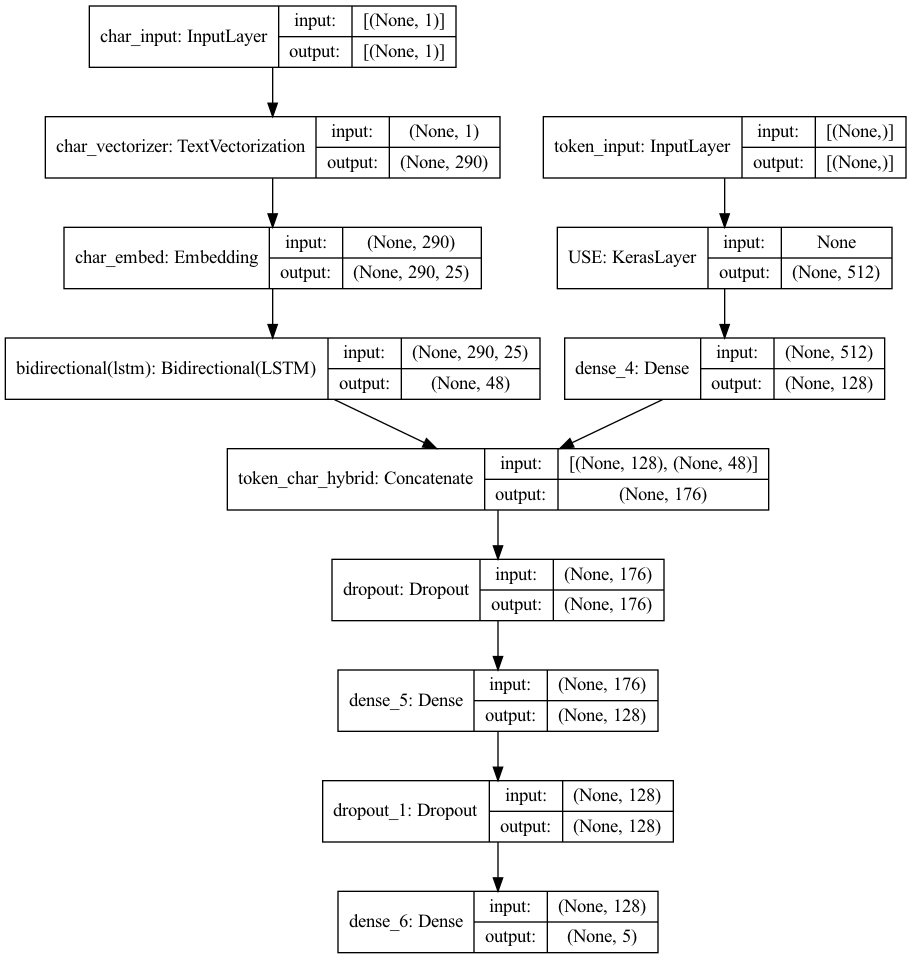

In [79]:
# plot hybrid model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [80]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [81]:
# combine chars and token into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# batch and prefetch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
# combine chars and token into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# batch and prefetch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
# combine chars and token into a dataset
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

# batch and prefetch train data
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
# check out the datasets
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [85]:
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=len(train_char_token_dataset),
                              epochs=100,
                              validation_data=val_char_token_dataset,
                              validation_steps=len(val_char_token_dataset),
                              callbacks=[early_stopping])

Epoch 1/100


2022-01-04 17:21:57.819003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 17:21:58.269944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 17:21:58.498643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 17:21:59.548996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 17:21:59.701941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - ETA: 0s - loss: 0.7568 - accuracy: 0.7071

2022-01-04 20:28:40.296501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 20:28:40.641020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 20:28:40.905931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - 11451s 2s/step - loss: 0.7568 - accuracy: 0.7071 - val_loss: 0.6518 - val_accuracy: 0.7512
Epoch 2/100
5627/5627 [==============================] - 11369s 2s/step - loss: 0.6523 - accuracy: 0.7498 - val_loss: 0.6266 - val_accuracy: 0.7608
Epoch 3/100
5627/5627 [==============================] - 11399s 2s/step - loss: 0.6133 - accuracy: 0.7646 - val_loss: 0.6194 - val_accuracy: 0.7644
Epoch 4/100
5627/5627 [==============================] - 11421s 2s/step - loss: 0.5863 - accuracy: 0.7757 - val_loss: 0.6182 - val_accuracy: 0.7655


In [86]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

2022-01-05 06:02:36.315759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 06:02:36.677835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 06:02:36.932288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[5.38429737e-01, 2.86470622e-01, 7.09515007e-04, 1.64384633e-01,
        1.00055737e-02],
       [2.90935785e-01, 6.46620512e-01, 7.55528279e-04, 6.06423877e-02,
        1.04572275e-03],
       [5.54593146e-01, 6.71281666e-03, 1.57462191e-02, 4.19021279e-01,
        3.92648485e-03],
       ...,
       [9.18977603e-05, 3.63286585e-04, 1.11061493e-02, 1.90352694e-05,
        9.88419533e-01],
       [1.98360644e-02, 1.13101445e-01, 3.00203949e-01, 1.16977887e-02,
        5.55160761e-01],
       [9.79418121e-03, 9.89795029e-01, 2.61122099e-04, 4.09589557e-05,
        1.08692591e-04]], dtype=float32)

In [87]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [88]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.54905335628227,
 'precision': 0.7623661123478228,
 'recall': 0.7654905335628227,
 'f1': 0.7612615815814936}

In [89]:
# create positional embeddings(line order matters)
# how many different line numbers are there
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

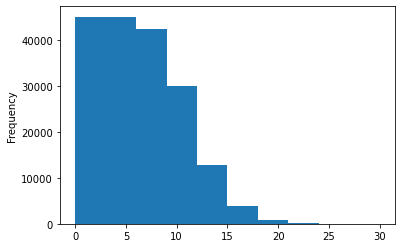

In [90]:
# check distributions
train_df.line_number.plot.hist()

(array([1.5000e+04, 0.0000e+00, 0.0000e+00, 1.5000e+04, 0.0000e+00,
        0.0000e+00, 1.5000e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5000e+04, 0.0000e+00, 0.0000e+00, 1.4992e+04, 0.0000e+00,
        0.0000e+00, 1.4949e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.4758e+04, 0.0000e+00, 0.0000e+00, 1.4279e+04, 0.0000e+00,
        0.0000e+00, 1.3346e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.1981e+04, 0.0000e+00, 0.0000e+00, 1.0041e+04, 0.0000e+00,
        0.0000e+00, 7.8920e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.8530e+03, 0.0000e+00, 0.0000e+00, 4.1520e+03, 0.0000e+00,
        0.0000e+00, 2.8350e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.8610e+03, 0.0000e+00, 0.0000e+00, 1.1880e+03, 0.0000e+00,
        0.0000e+00, 7.5100e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.6200e+02, 0.0000e+00, 0.0000e+00, 2.8600e+02, 0.0000e+00,
        0.0000e+00, 1.6200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0100e+02, 0.0000e+00, 0.0000e+00, 6.60

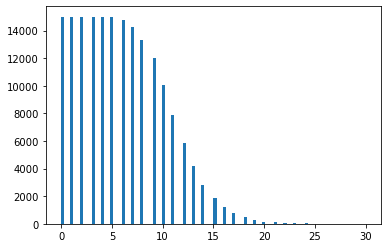

In [91]:
plt.hist(train_df.line_number, bins=100)

In [92]:
# use tf to create one-hot-encoded tensors for line number
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [93]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [94]:
# how many different numebrs of lines are there
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

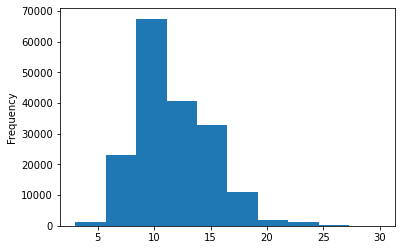

In [95]:
train_df.total_lines.plot.hist()

In [96]:
# check the coverage of a 'total_lines' value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [97]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [98]:
# token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name='line_number_inputs')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

# combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='token_char_hybrid_embedding')([token_model.output, char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# combine positional embeddings with combined token and char hybrid embeddings
z = layers.Concatenate(name='token_char_positional_embedding')([line_number_model.output, total_lines_model.output, z])

# create output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(z)

model_5 = tf.keras.Model(
    inputs=[
        line_number_inputs,
        total_lines_inputs,
        token_inputs,
        char_inputs
        ],
    outputs=output_layer
)

In [99]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________________________

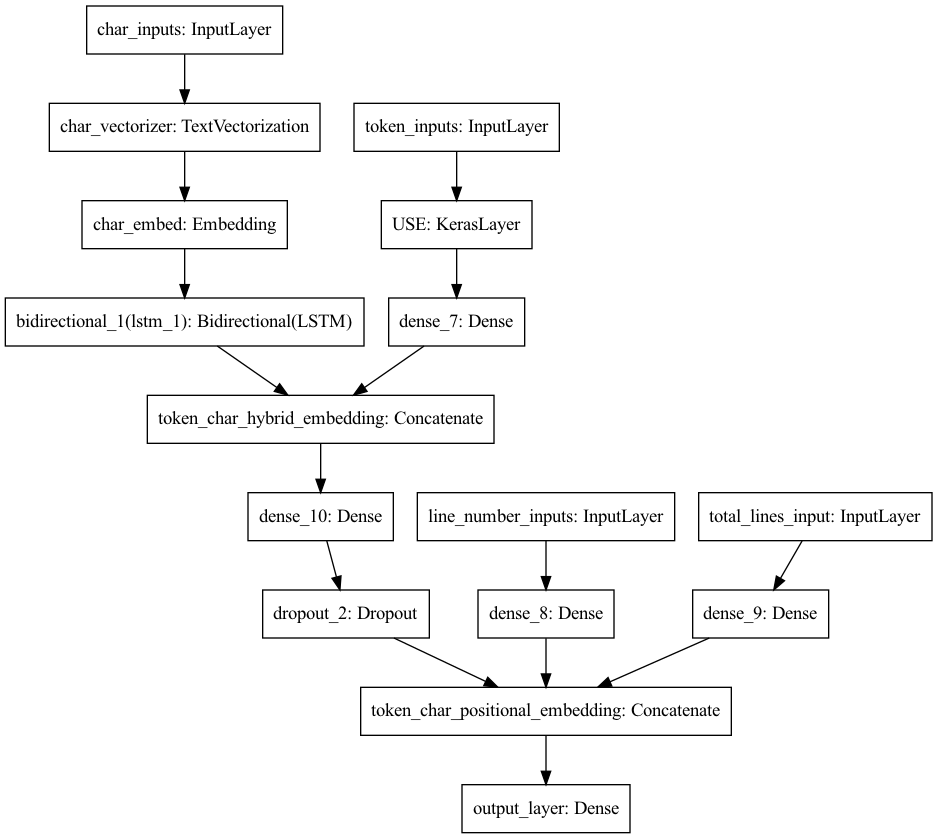

In [100]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [101]:
# compile model with label smoothing to fight against overfitting
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=Adam(),
    metrics=['accuracy']
)

In [102]:
# create performant datasets
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_sentences,
    train_chars
))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars
))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    test_line_numbers_one_hot,
    test_total_lines_one_hot,
    test_sentences,
    test_chars
))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [103]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=len(train_pos_char_token_dataset),
                              epochs=100,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=len(val_pos_char_token_dataset),
                              callbacks=[early_stopping]
                              )

Epoch 1/100


2022-01-05 06:06:38.720101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 06:06:39.328206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 06:06:39.677019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 06:06:41.204848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 06:06:41.410218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - ETA: 0s - loss: 0.9549 - accuracy: 0.8187

2022-01-05 09:18:14.949049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 09:18:15.699853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 09:18:16.070388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5627/5627 [==============================] - 11796s 2s/step - loss: 0.9549 - accuracy: 0.8187 - val_loss: 0.9136 - val_accuracy: 0.8442
Epoch 2/100
5627/5627 [==============================] - 11834s 2s/step - loss: 0.9075 - accuracy: 0.8509 - val_loss: 0.9045 - val_accuracy: 0.8485
Epoch 3/100
5627/5627 [==============================] - 12039s 2s/step - loss: 0.8925 - accuracy: 0.8620 - val_loss: 0.9029 - val_accuracy: 0.8487


In [104]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

2022-01-05 16:01:06.063748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 16:01:06.767924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 16:01:07.315831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


945/945 [==============================] - 307s 322ms/step


array([[0.6424052 , 0.10436901, 0.02408212, 0.19709708, 0.03204663],
       [0.5308159 , 0.1141073 , 0.05777612, 0.26036432, 0.03693639],
       [0.39504358, 0.10574227, 0.07426349, 0.37907803, 0.04587268],
       ...,
       [0.0308229 , 0.1113534 , 0.02737921, 0.03661571, 0.7938287 ],
       [0.01945031, 0.42455888, 0.08613048, 0.02385546, 0.44600484],
       [0.06052208, 0.8559624 , 0.02931811, 0.02013113, 0.0340663 ]],
      dtype=float32)

In [105]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [106]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 84.87356017476499,
 'precision': 0.8496865894335313,
 'recall': 0.84873560174765,
 'f1': 0.8461785954034059}

In [107]:
# compare results
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,81.086985,0.808859,0.810870,0.808042
pretrained_token_embed,77.359989,0.771585,0.773600,0.769482
custom_char_embed_conv1d,72.888256,0.730720,0.728883,0.721662
hybrid_char_token_embed,76.549053,0.762366,0.765491,0.761262
tribrid_pos_char_token_embed,84.873560,0.849687,0.848736,0.846179


In [108]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

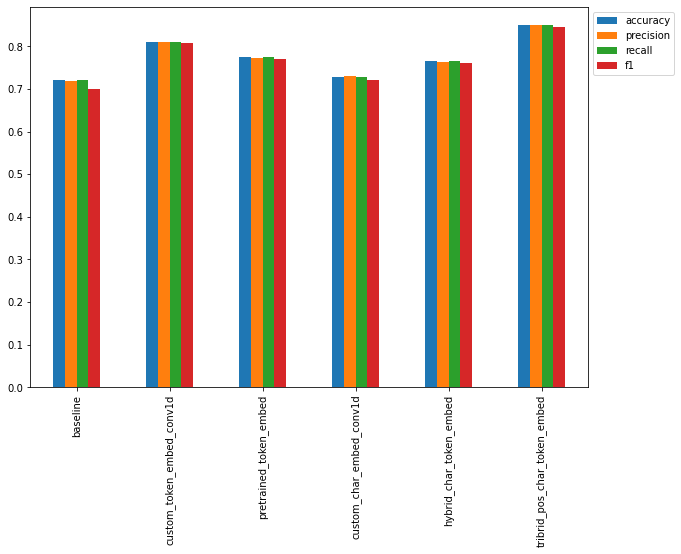

In [109]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<AxesSubplot:>

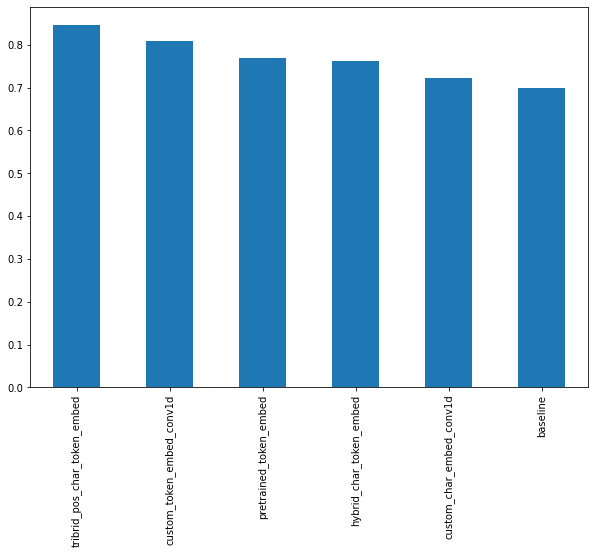

In [110]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

In [113]:
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string
#model_5.save("skimlit_tribrid_model_hdf5.h5")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [114]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 302s 321ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [115]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 84.4931143188983,
 'precision': 0.84482191138137,
 'recall': 0.8449311431889829,
 'f1': 0.8420900180232334}

In [ ]:
# find most wrong

In [116]:
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

['BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',

In [117]:
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,BACKGROUND,0.383696,True
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.380050,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.812808,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.547288,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.684606,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.833384,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.782848,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.701889,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.637814,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.674581,True


In [118]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.953611,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.948357,False
20427,OBJECTIVE,the national institute of neurological disorde...,1,18,BACKGROUND,0.944702,False
12164,BACKGROUND,present study evaluates netprotect in a phase ...,2,16,METHODS,0.932343,False
22736,OBJECTIVE,"the national institute of oncology , budapest ...",4,20,METHODS,0.931632,False
...,...,...,...,...,...,...,...
17223,RESULTS,management was provided by the patient 's phys...,2,12,METHODS,0.838786,False
6028,RESULTS,courses were repeated every @ to @ weeks .,5,15,METHODS,0.838488,False
13472,BACKGROUND,in this blended intervention face-to-face cont...,4,17,METHODS,0.838435,False
18206,OBJECTIVE,in a randomized controlled trial we examined t...,2,12,METHODS,0.838369,False


In [119]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: METHODS, Pred: BACKGROUND, Prob: 0.9536113142967224, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9483567476272583, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: OBJECTIVE, Pred: BACKGROUND, Prob: 0.9447017908096313, Line number: 1, Total lines: 18

Text:
the national institute of neurological disorders and stroke exploratory trials in parkinson disease program was established to promote discovery of potential therapies .

-----

Target: BACKGROUND, Pred: METHODS, Prob: 0.9323434233665466, Line number: 2, Total lines: 16

Text:
present study evaluates netprotect in a phase iii trial in rural cambodia .

-----

Target: OBJECTIVE, Pred: METHODS, Prob: 0.9316321611404419, Line number: 4, Total lines: 20

Text:
the national institute of oncology , budapest conducted a single centre randomized clinical study .

-----

Target: RESULTS, 

In [ ]:
# test on wild abstract
# 1. Split it into sentences (lines).
# 2. Split it into characters.
# 3. Find the number of each line.
# 4. Find the total number of lines.